In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
from sklearn.preprocessing import MinMaxScaler

#### Importing Dataset from Yahoo Finance

**Common Tickers include: ['TSLA','FB','AMZN','GOOG','TWTR']**

In [2]:
import yfinance as yf
stock_symbol = 'PYPL'
data = yf.download(tickers=stock_symbol,period='2y',interval='1d')
data = data.reset_index()
data.tail()

[*********************100%***********************]  1 of 1 completed


,Date,Open,High,Low,Close,Adj Close,Volume
500,2022-04-21,96.135002,97.610001,88.809998,89.400002,89.400002,27204100
501,2022-04-22,89.294998,90.250000,85.980003,86.029999,86.029999,20972600
502,2022-04-25,85.324997,87.930000,84.419998,87.779999,87.779999,15683400
503,2022-04-26,86.769997,86.864998,83.570000,83.699997,83.699997,17205300
504,2022-04-27,83.570000,86.605003,82.120003,82.610001,82.610001,24556100


#### Visualizing the Real Stock Trend

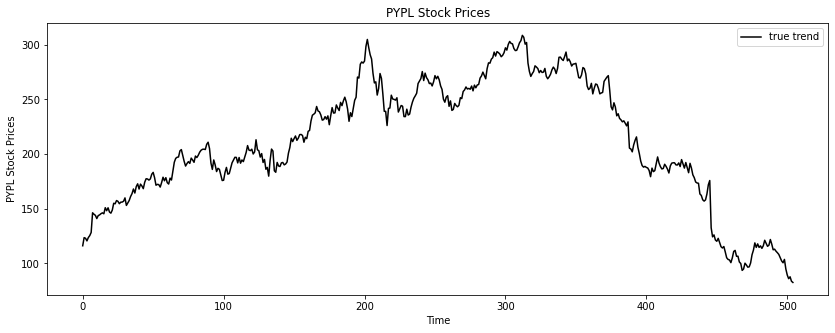

In [3]:
plt.figure(figsize=(14,5))
plt.plot(data['Close'],color='black',label='true trend')
plt.title('%s Stock Prices'%stock_symbol)
plt.xlabel('Time')
plt.ylabel('%s Stock Prices'%stock_symbol)
plt.legend()
plt.show()

#### Marking a training timeframe of 60 days

In [579]:
test_size = 60
data_train = data[:-test_size]
data_test = data[-test_size:]
data.shape,data_train.shape,data_test.shape

((505, 7), (445, 7), (60, 7))

#### Preparing the training data

In [580]:
training_data = data_train.drop(['Date','Adj Close'],axis=1)
training_data.head()

,Open,High,Low,Close,Volume
0,110.290001,116.000000,109.910004,115.190002,12874300
1,115.940002,118.385002,115.000000,115.239998,7563200
2,115.470001,120.470001,115.400002,120.180000,10677500
3,121.250000,122.387001,120.055000,120.529999,6678200
4,121.660004,122.000000,115.903000,116.139999,9192300


In [581]:
scaler = MinMaxScaler()
training_data = scaler.fit_transform(training_data)
training_data[0]

array([0.        , 0.        , 0.        , 0.        , 0.16114687])

In [582]:
# Preparing the training set
x_train = []
y_train = []

for i in range(test_size, training_data.shape[0]):
    x_train.append(training_data[i-test_size:i])
    y_train.append(training_data[i,3])
# last 60 days will be the training set - X
# 61st day is the target value - Y

x_train = np.array(x_train)
y_train = np.array(y_train)

x_train.shape,y_train.shape

((385, 60, 5), (385,))

#### Preparaing testing data

In [583]:
past_test_days = data_train.tail(test_size)
df = pd.concat([past_test_days,data_test])
df = df.drop(['Date','Adj Close'],axis='columns')
df.shape, df.head()

((120, 5),
            Open        High         Low       Close    Volume
 385  235.429993  238.899994  231.710007  232.589996  13010800
 386  232.699997  233.550003  230.190002  231.279999  14054900
 387  232.539993  232.761002  227.800003  229.460007  12676700
 388  228.330002  230.899994  225.309998  230.380005  14178000
 389  231.610001  231.919998  225.000000  228.220001  14158900)

In [584]:
df = scaler.transform(df)
df[0]

array([0.62767713, 0.63298306, 0.62359205, 0.60722042, 0.16338673])

In [585]:
x_test = []
y_test = []

for i in range(test_size,df.shape[0]):
    x_test.append(df[i-test_size:i])
    y_test.append(df[i,3])

x_test, y_test = np.array(x_test),np.array(y_test)
x_test.shape, y_test.shape

((60, 60, 5), (60,))

#### Defining the Scaling Label

In [586]:
# below is the scaling label, which will help inverse the transformation back to it's original values 
data_close = data.Close
data_close = data_close.values.reshape(-1, 1)
scaler_close = MinMaxScaler()
data_close_scaled = scaler_close.fit_transform(data_close)

In [587]:
y_test = y_test.reshape(-1,1)
y_test = scaler_close.inverse_transform(y_test)

#### GRU - Gated Recurrent Unit

In [588]:
from keras.models import Sequential
from keras.layers import Dense, GRU, Dropout

In [589]:
x_train.shape[1],x_train.shape[2]

(60, 5)

In [590]:
model = Sequential()

# Input layer
model.add(GRU(units=40,activation='relu',return_sequences=False, input_shape=(x_train.shape[1],x_train.shape[2])))
model.add(Dropout(0.5))

# output layer
model.add(Dense(units=1))

model.summary()

Model: "sequential_23"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_23 (GRU)                (None, 40)                5640      
                                                                 
 dropout_23 (Dropout)        (None, 40)                0         
                                                                 
 dense_23 (Dense)            (None, 1)                 41        
                                                                 
Total params: 5,681
Trainable params: 5,681
Non-trainable params: 0
_________________________________________________________________


In [591]:
model.compile(optimizer='adam',loss='mean_squared_error',metrics=['accuracy'])

In [592]:
def forecast():
    model.fit(x_train,y_train,epochs=300,batch_size=32)
    y_pred = model.predict(x_test)
    y_pred = y_pred.reshape(-1,1)
    y_pred = scaler_close.inverse_transform(y_pred)
    return y_pred

In [593]:
def first_forecast():
    history = model.fit(x_train,y_train,epochs=300,batch_size=32)
    y_pred = model.predict(x_test)
    y_pred = y_pred.reshape(-1,1)
    y_pred = scaler_close.inverse_transform(y_pred)
    return history,y_pred

In [594]:
result_forecast = []
simulation = 1
print("Simulation 1")
history,first_result = first_forecast()
result_forecast.append(first_result)
for i in range(1,simulation):
    print("Simulation %d"%(i+1))
    result_forecast.append(forecast())


Simulation 1
Epoch 1/300
13/13 [==============================] - 2s 20ms/step - loss: 0.3675 - accuracy: 0.0000e+00
Epoch 2/300
13/13 [==============================] - 1s 40ms/step - loss: 0.1685 - accuracy: 0.0000e+00
Epoch 3/300
13/13 [==============================] - 0s 21ms/step - loss: 0.0751 - accuracy: 0.0026
Epoch 4/300
13/13 [==============================] - 0s 23ms/step - loss: 0.0584 - accuracy: 0.0026
Epoch 5/300
13/13 [==============================] - 0s 22ms/step - loss: 0.0561 - accuracy: 0.0026
Epoch 6/300
13/13 [==============================] - 0s 22ms/step - loss: 0.0411 - accuracy: 0.0026
Epoch 7/300
13/13 [==============================] - 0s 24ms/step - loss: 0.0401 - accuracy: 0.0026
Epoch 8/300
13/13 [==============================] - 0s 20ms/step - loss: 0.0360 - accuracy: 0.0026
Epoch 9/300
13/13 [==============================] - 0s 26ms/step - loss: 0.0372 - accuracy: 0.0026
Epoch 10/300
13/13 [==============================] - 0s 21ms/step - loss: 0.03

#### Calculating the Accuracy using MAPE and RMSE

In [595]:
# MAPE - Mean Absolute Percentage Error
def calculate_accuracy(real, predict):
    real = np.array(real) + 1
    predict = np.array(predict) + 1
    percentage = 1 - np.mean(np.abs((real-predict)/real))
    return percentage * 100
mean_accuracy = []
for i in range(simulation):
    mean_accuracy.append(calculate_accuracy(y_test, result_forecast[i]))

mean_accuracy

[53.147525025733955]

In [596]:
# RMSE - Root Mean Squared Error 
def calculate_rmse(real, predict):
    real = np.array(real) + 1
    predict = np.array(predict) + 1
    percentage = 1 - np.sqrt(np.mean(np.square((real - predict)/real)))
    return percentage * 100
mean_rmse = []
for i in range(simulation):
    mean_rmse.append(calculate_rmse(y_test, result_forecast[i]))

mean_rmse,np.mean(mean_rmse)

([50.39943467137592], 50.39943467137592)

#### Visualization

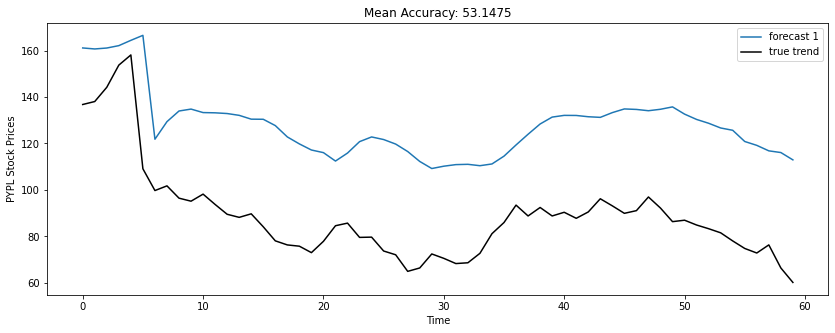

In [597]:
plt.figure(figsize=(14,5))
for i in range(simulation):
    plt.plot(result_forecast[i],label='forecast %d'%(i+1))
plt.plot(y_test,color='black',label='true trend')
plt.title('Mean Accuracy: %.4f'%np.mean(mean_accuracy))
plt.xlabel('Time')
plt.ylabel('%s Stock Prices'%stock_symbol)
plt.legend()
plt.show()

In [598]:
history.history.keys()

dict_keys(['loss', 'accuracy'])

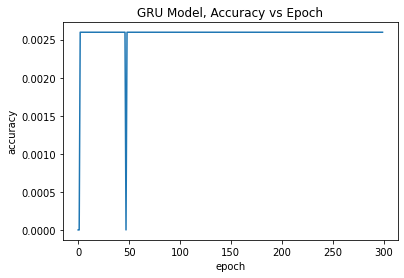

In [599]:
plt.plot(history.history['accuracy'])
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.title('GRU Model, Accuracy vs Epoch')
plt.show()

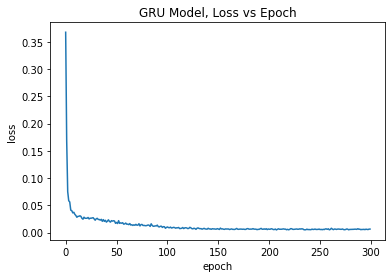

In [600]:
plt.plot(history.history['loss'])
plt.ylabel('loss')
plt.xlabel('epoch')
plt.title('GRU Model, Loss vs Epoch')
plt.show()

In [601]:
present_test_set = data_test
present_test_set = present_test_set.drop(['Date','Adj Close'],axis=1)

#scale the data
present_input = scaler.transform(present_test_set)

# preparing the arrays according to the test_size
present_test = []
present_test.append(present_input)

for i in range(1,test_size):
    a = [0,0,0,0,0]
    ar = []
    for j in range(0,test_size):
        ar.append(a)
    present_test.append(ar)

present_test = np.array(present_test)

y = model.predict(present_test)
predicted_value = y.reshape(-1,1)
predicted_value = scaler_close.inverse_transform(predicted_value)
print("Next Day's Predicted Closing Index = %f"%predicted_value[0])

Next Day's Predicted Closing Index = 108.594536


### Final Analysis

>**Dataset:**
>* GOOG
>* 2y  
>
>**Training Timestamp:**
>* 60 days
>  
>**Model:**
>* 2 layers - (1 Input + 1 Output)
>* GRU layer - activation = relu
>* GRU layer - units = 40
>* GRU layers - dropout = 0.2
>* Dense layer - units = 1  
>
>**Compile:**
>* optimizer = adam
>
>**Training:**
>* epochs: 300
>* batch_size = 32
>
>**Mean Accuracy:**
>* MAPE - 93.09%
>* RMSE - 91.39%

**Predicted Closing Index for 29th March: 2806.769043**